In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import torch as torch
import nltk
from datasets import load_dataset
import torch 


In [38]:
!git config --global user.email "horatiuwest@yahoo.com"
!git config --global user.name "Frincu Horatiu"

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



In [21]:
dataset = load_dataset('csv', data_files = 'spotify_millsongdata.csv')


In [36]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['artist', 'song', 'link', 'text'],
        num_rows: 57650
    })
})


In [22]:
from transformers import GPT2Tokenizer, GPT2Model
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from transformers import GPT2TokenizerFast


model = GPT2Model.from_pretrained('gpt2-medium')
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))


In [39]:
from transformers import pipeline
summarizer = pipeline("summarization", model="Stancld/longt5-tglobal-large-16384-pubmed-3k_steps")


lista_summ = []
for i in range(dataset.num_rows):
    lista_summ.append(summarizer(dataset['train']['text'][i])[0]['summary_text'])
df_train = pd.DataFrame(dataset['train'])
df_train['sum'] = lista_summ


from datasets import Dataset
dataset = Dataset.from_pandas(df_train)

TypeError: 'dict' object cannot be interpreted as an integer

In [23]:
encoded_input = tokenizer("melodie gen abba", return_tensors="pt")
encoded_input
max_length = model.config.max_position_embeddings
if len(encoded_input["input_ids"][0]) > max_length:
    print("Tokenized sequence exceeds model's maximum input length.")

In [24]:
MAX_LENGTH = 256
BATCH_SIZE = 6
tokenized_data = tokenizer(
    dataset['train']['text'],
    truncation = True,
    max_length = MAX_LENGTH,
    return_overflowing_tokens = True,
    return_length = True
)
tokenized_data = {"input_ids": tokenized_data["input_ids"]}


In [25]:

def preprocess(example):
    try:
        outputs = tokenizer(
        example["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        return_overflowing_tokens=True,
        return_length=True,
        padding="max_length",  # Aceasta va utiliza pad_token implicit
        return_tensors="pt"
    )

        
        input_batch = outputs["input_ids"].tolist()

        if len(input_batch) < BATCH_SIZE:
            input_batch += [input_batch[0]] * (BATCH_SIZE - len(input_batch))
    except Exception as e:
        print(f"An error occurred: {e}")
        input_batch = []

    return {"input_ids": input_batch}


tokenized_dataset = dataset.map(preprocess, remove_columns = dataset['train'].column_names)


In [26]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 57650
    })
})

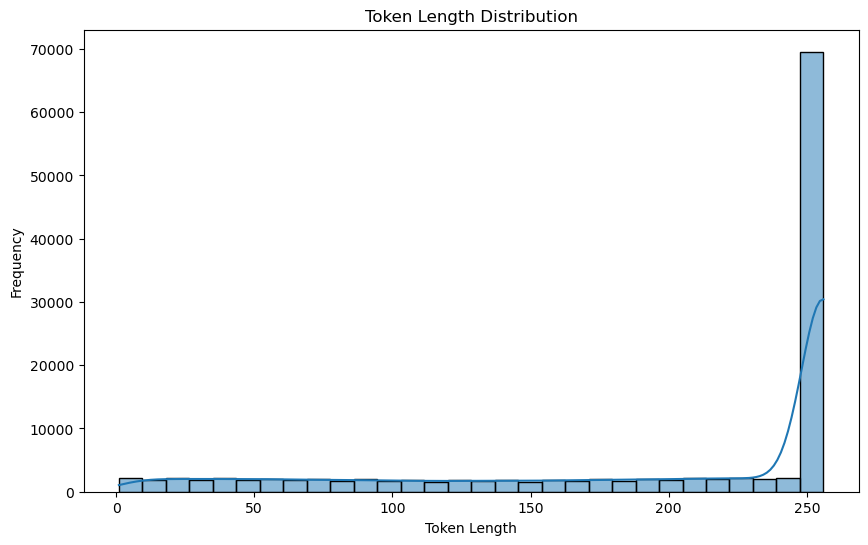

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

token_lengths = [len(tokens) for tokens in tokenized_data["input_ids"]]

plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, bins=30, kde=True)
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()


In [42]:
from collections import Counter

all_tokens = [token for tokens in tokenized_data["input_ids"] for token in tokens]

top_tokens = Counter(all_tokens).most_common(10)

print("Top 10 tokens:", top_tokens)


Top 10 tokens: [(220, 4508827), (201, 2370066), (198, 2370066), (11, 558917), (262, 446776), (345, 396283), (314, 356928), (284, 275390), (40, 244862), (257, 241316)]


In [46]:
prompts = ["melodie gen abba", "Ceva in stil Eminem", "ce ar canta taylor swift"]

tokenized_prompts = tokenizer(prompts, return_tensors="pt")

print(tokenized_prompts)


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

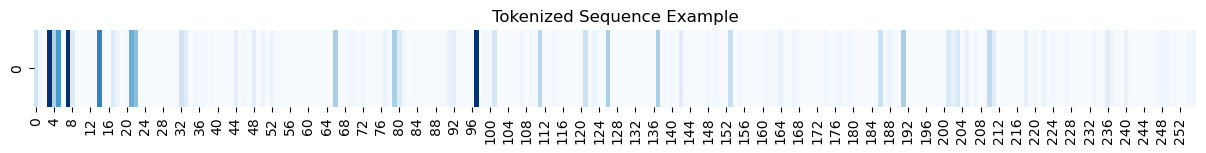

In [45]:
import random

random_sequence = random.choice(tokenized_data["input_ids"])

plt.figure(figsize=(15, 1))
sns.heatmap([random_sequence], cmap='Blues', cbar=False, annot=False)
plt.title('Tokenized Sequence Example')
plt.show()


In [27]:
def filter_none(example):
    if len(example['input_ids']) >= 1:
        return example
final_data = tokenized_dataset.filter(filter_none)
final_data



DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 57650
    })
})

In [28]:
tokenizer.pad_token = tokenizer.eos_token
data_col = DataCollatorForLanguageModeling(tokenizer, mlm = False, return_tensors = "tf") # mlm = masked language modeling

tf_train_dataset = final_data["train"].to_tf_dataset(
    columns = ['input_ids', 'attention_mask', 'labels'],
    shuffle = True,
    batch_size = 1,
    collate_fn = data_col
)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [29]:
import tensorflow as tf
attention_mask = tf.ones([BATCH_SIZE, MAX_LENGTH])
def swap_position(example):
    return {
        'input_ids': example['input_ids'],
        'attention_mask': tf.ones([BATCH_SIZE, MAX_LENGTH]),
        'labels': example['labels']
    }
train_data = tf_train_dataset.map(swap_position)
unbatched_train_data = train_data.unbatch()


In [30]:
from transformers import TFGPT2LMHeadModel
model = TFGPT2LMHeadModel.from_pretrained('gpt2-medium')
model.summary()

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  354823168 
 er)                                                             
                                                                 
Total params: 354823168 (1.32 GB)
Trainable params: 354823168 (1.32 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
from transformers import create_optimizer
from tensorflow.keras.optimizers.legacy import Adam

num_train_steps = len(unbatched_train_data)

optimizer, schedule = create_optimizer(
    init_lr = 5e-5,
    num_warmup_steps = 1_000,
    num_train_steps = num_train_steps
)

model.compile(
    optimizer = optimizer
)


In [37]:
from transformers import pipeline
summarizer = pipeline("summarization", model="Stancld/longt5-tglobal-large-16384-pubmed-3k_steps")


lista_summ = []
for i in range(1):
    lista_summ.append(summarizer(dataset['train']['text'][i])[0]['summary_text'])
df_train = pd.DataFrame(dataset['train'])
df_train['sum'] = lista_summ


from datasets import Dataset
dataset = Dataset.from_pandas(df_train)

config.json:   0%|          | 0.00/853 [00:00<?, ?B/s]

C:\Users\Heshy\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Heshy\.cache\huggingface\hub\models--Stancld--longt5-tglobal-large-16384-pubmed-3k_steps. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  *,


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/repos/f2/69/f26904b790f65b77ba03b9571c7c995c122b4becfe705e379d84da0f3c91186d/0c1ed1e20e6882aa95db090b26538bb1894fd82de28234afc6ea6bec351c7c28?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1705588151&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNTU4ODE1MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9mMi82OS9mMjY5MDRiNzkwZjY1Yjc3YmEwM2I5NTcxYzdjOTk1YzEyMmI0YmVjZmU3MDVlMzc5ZDg0ZGEwZjNjOTExODZkLzBjMWVkMWUyMGU2ODgyYWE5NWRiMDkwYjI2NTM4YmIxODk0ZmQ4MmRlMjgyMzRhZmM2ZWE2YmVjMzUxYzdjMjg%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=qyPP8AIZabIFKz6NagSS-BduP8mZVghc%7Ea4SZO%7EvTUkVB2xJDiOuChxgMLHxpoLhLdbE28D0x%7Ezu4m5gsX4EBo26IK0SPwREBJEJMD0nVyoRqTLPQ9pNqDhBgOiU8%7ERiJrf%7EdD1C93oub6PPopjRQsG3f4uaLuS8eu2HIaDTYDVAw9wlJVKBtidghmCiqbYcnW4HJwpbYeNTuA74wo8FSMfF67Ry6JsfVi5P38xR

model.safetensors:  59%|#####8    | 1.85G/3.13G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

C:\Users\Heshy\anaconda3\Lib\site-packages\transformers\generation\utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
C:\Users\Heshy\anaconda3\Lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


ValueError: Length of values (1) does not match length of index (57650)

In [33]:
train_history = model.fit(unbatched_train_data, epochs = 5)
# train_history = model.fit(
#     unbatched_train_data.map(lambda x: {'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']}),
#     epochs=5
# )


Epoch 1/5


StagingError: in user code:

    File "C:\Users\Heshy\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Heshy\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Heshy\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Heshy\anaconda3\Lib\site-packages\transformers\modeling_tf_utils.py", line 1641, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Heshy\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    StagingError: Exception encountered when calling layer 'tfgpt2lm_head_model_1' (type TFGPT2LMHeadModel).
    
    in user code:
    
        File "C:\Users\Heshy\anaconda3\Lib\site-packages\transformers\modeling_tf_utils.py", line 815, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "C:\Users\Heshy\anaconda3\Lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 847, in call  *
            transformer_outputs = self.transformer(
        File "C:\Users\Heshy\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        StagingError: Exception encountered when calling layer 'transformer' (type TFGPT2MainLayer).
        
        in user code:
        
            File "C:\Users\Heshy\anaconda3\Lib\site-packages\transformers\modeling_tf_utils.py", line 815, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "C:\Users\Heshy\anaconda3\Lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 390, in call  *
                attention_mask = tf.reshape(attention_mask, (attention_mask_shape[0], 1, 1, attention_mask_shape[1]))
        
            IndexError: list index out of range
        
        
        Call arguments received by layer 'transformer' (type TFGPT2MainLayer):
          • input_ids=tf.Tensor(shape=(6, 256), dtype=int32)
          • past_key_values=None
          • attention_mask=tf.Tensor(shape=(256,), dtype=float32)
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • use_cache=True
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer 'tfgpt2lm_head_model_1' (type TFGPT2LMHeadModel):
      • input_ids={'input_ids': 'tf.Tensor(shape=(6, 256), dtype=int64)', 'attention_mask': 'tf.Tensor(shape=(256,), dtype=float32)', 'labels': 'tf.Tensor(shape=(6, 256), dtype=int64)'}
      • past_key_values=None
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • encoder_hidden_states=None
      • encoder_attention_mask=None
      • use_cache=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=True
